In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

import time
import os

from numpy import *
from math import sqrt
from pandas import *
from datetime import datetime, timedelta

from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error

from tensorflow.keras import Sequential, regularizers
from tensorflow.keras.layers import Dense, Dropout, Bidirectional
from tensorflow.keras.layers import BatchNormalization, Embedding, TimeDistributed, LeakyReLU
from tensorflow.keras.layers import LSTM, GRU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Flatten, Conv1D, ELU, ReLU, Dropout

from matplotlib import pyplot
from pickle import load

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
X_train = np.load("/content/drive/MyDrive/Project/X_train.npy", allow_pickle=True)
y_train = np.load("/content/drive/MyDrive/Project/y_train.npy", allow_pickle=True)
X_test = np.load("/content/drive/MyDrive/Project/X_test.npy", allow_pickle=True)
y_test = np.load("/content/drive/MyDrive/Project/y_test.npy", allow_pickle=True)
yc_train = np.load("/content/drive/MyDrive/Project/yc_train.npy", allow_pickle=True)
yc_test = np.load("/content/drive/MyDrive/Project/yc_test.npy", allow_pickle=True)

In [ ]:
LR = 0.001
BATCH_SIZE = 64
N_EPOCH = 50

In [ ]:
input_dim = X_train.shape[1]
feature_size = X_train.shape[2]
output_dim = y_train.shape[1]

In [ ]:
def basic_lstm(input_dim, feature_size):
    model = Sequential()
    model.add(Bidirectional(LSTM(units= 128), input_shape=(input_dim, feature_size)))
    model.add(Dense(64))
    model.add(Dense(units=output_dim))
    model.compile(optimizer=Adam(lr = LR), loss='mse')
    history = model.fit(X_train, y_train, epochs=N_EPOCH, batch_size=BATCH_SIZE, validation_data=(X_test, y_test),
                        verbose=2, shuffle=False)

    pyplot.plot(history.history['loss'], label='train')
    pyplot.plot(history.history['val_loss'], label='validation')
    pyplot.legend()
    pyplot.show()

    return model

Epoch 1/50
92/92 - 15s - loss: 0.0490 - val_loss: 0.0123 - 15s/epoch - 160ms/step
Epoch 2/50
92/92 - 1s - loss: 0.0109 - val_loss: 0.1824 - 583ms/epoch - 6ms/step
Epoch 3/50
92/92 - 1s - loss: 0.0330 - val_loss: 0.0266 - 590ms/epoch - 6ms/step
Epoch 4/50
92/92 - 1s - loss: 0.0225 - val_loss: 0.0681 - 581ms/epoch - 6ms/step
Epoch 5/50
92/92 - 1s - loss: 0.0117 - val_loss: 0.0122 - 522ms/epoch - 6ms/step
Epoch 6/50
92/92 - 1s - loss: 0.0085 - val_loss: 0.0018 - 523ms/epoch - 6ms/step
Epoch 7/50
92/92 - 1s - loss: 0.0066 - val_loss: 0.0113 - 570ms/epoch - 6ms/step
Epoch 8/50
92/92 - 1s - loss: 0.0115 - val_loss: 0.0196 - 536ms/epoch - 6ms/step
Epoch 9/50
92/92 - 1s - loss: 0.0043 - val_loss: 0.0207 - 530ms/epoch - 6ms/step
Epoch 10/50
92/92 - 1s - loss: 0.0084 - val_loss: 0.0332 - 543ms/epoch - 6ms/step
Epoch 11/50
92/92 - 1s - loss: 0.0072 - val_loss: 0.0071 - 527ms/epoch - 6ms/step
Epoch 12/50
92/92 - 1s - loss: 0.0048 - val_loss: 0.0135 - 525ms/epoch - 6ms/step
Epoch 13/50
92/92 - 1s -

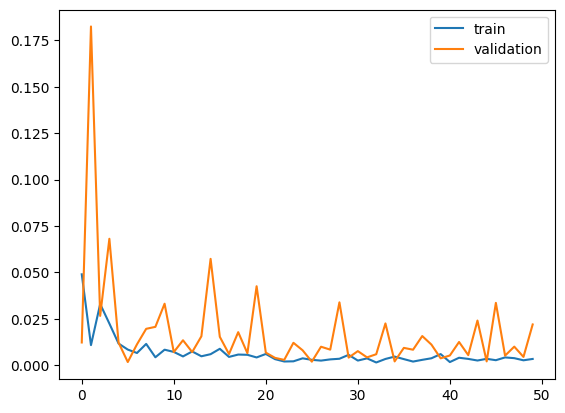

In [ ]:
model = basic_lstm(input_dim, feature_size)

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 256)              152576    
 l)                                                              
                                                                 
 dense (Dense)               (None, 64)                16448     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 169,089
Trainable params: 169,089
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.save('/content/drive/MyDrive/Project/LSTM_3to1.h5')

In [ ]:
yhat = model.predict(X_test, verbose=0)

In [ ]:
rmse = sqrt(mean_squared_error(y_test, yhat))
rmse

0.1483035101610973

In [ ]:
def plot_traindataset_result(X_train, y_train):

    train_yhat = model.predict(X_train, verbose=0)

    X_scaler = load(open('/content/drive/MyDrive/Project/X_scaler.pkl', 'rb'))
    y_scaler = load(open('/content/drive/MyDrive/Project/y_scaler.pkl', 'rb'))
    train_predict_index = np.load("/content/drive/MyDrive/Project/index_train.npy", allow_pickle=True)

    rescaled_real_y = y_scaler.inverse_transform(y_train)
    rescaled_predicted_y = y_scaler.inverse_transform(train_yhat)

    predict_result = pd.DataFrame()
    for i in range(rescaled_predicted_y.shape[0]):
        y_predict = pd.DataFrame(rescaled_predicted_y[i], columns=["predicted_price"],
                                 index=train_predict_index[i:i + output_dim])
        predict_result = pd.concat([predict_result, y_predict], axis=1, sort=False)

    real_price = pd.DataFrame()
    for i in range(rescaled_real_y.shape[0]):
        y_train = pd.DataFrame(rescaled_real_y[i], columns=["real_price"],
                               index=train_predict_index[i:i + output_dim])
        real_price = pd.concat([real_price, y_train], axis=1, sort=False)

    predict_result['predicted_mean'] = predict_result.mean(axis=1)
    real_price['real_mean'] = real_price.mean(axis=1)

    # Plot the predicted result
    plt.figure(figsize=(16, 8))
    plt.plot(real_price["real_mean"])
    plt.plot(predict_result["predicted_mean"], color='r')
    plt.xlabel("Date")
    plt.ylabel("Stock price")
    plt.legend(("Real price", "Predicted price"), loc="upper left", fontsize=16)
    plt.title("The result of Training", fontsize=20)
    plt.show()

    # Calculate RMSE
    predicted = predict_result["predicted_mean"]
    real = real_price["real_mean"]
    RMSE = np.sqrt(mean_squared_error(predicted, real))
    print('Train RMSE:', RMSE)

    return RMSE

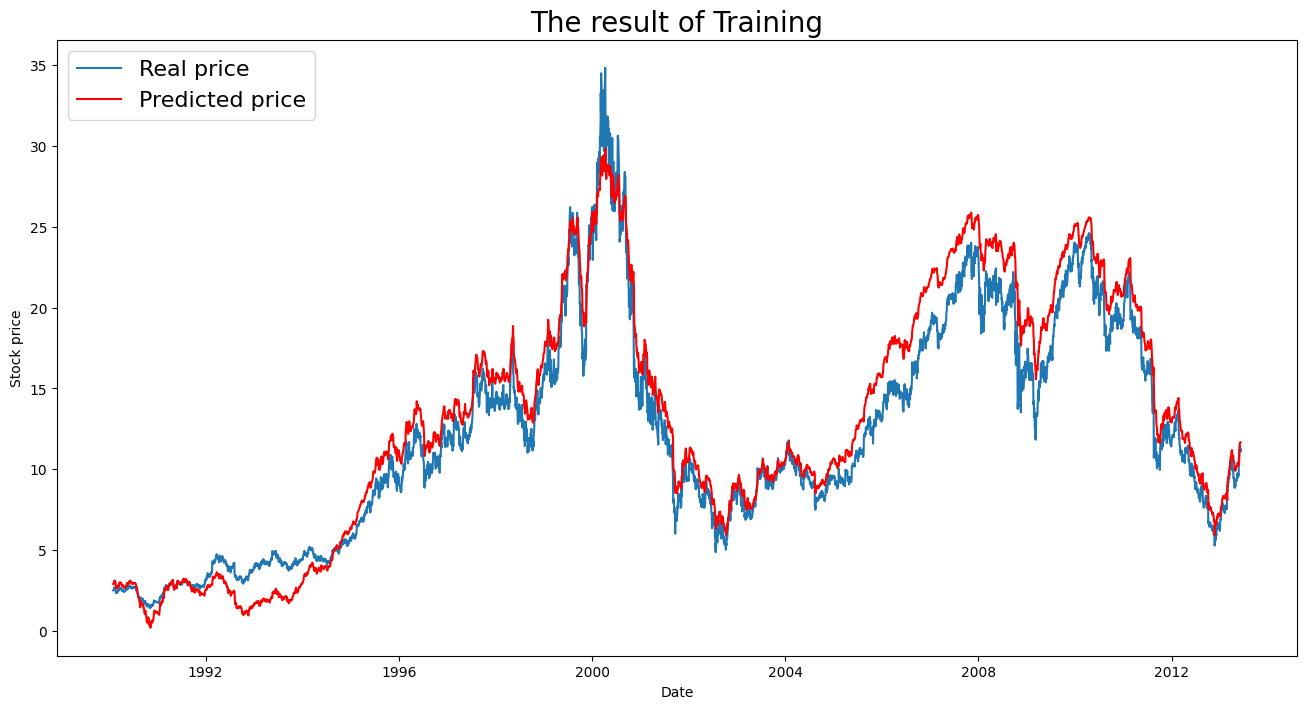

In [ ]:
train_RMSE = plot_traindataset_result(X_train, y_train)

In [ ]:
def plot_testdataset_result(X_test, y_test):

    test_yhat = model.predict(X_test, verbose=0)

    y_scaler = load(open('/content/drive/MyDrive/Project/y_scaler.pkl', 'rb'))
    test_predict_index = np.load("/content/drive/MyDrive/Project/index_test.npy", allow_pickle=True)

    rescaled_real_y = y_scaler.inverse_transform(y_test)
    rescaled_predicted_y = y_scaler.inverse_transform(test_yhat)

    predict_result = pd.DataFrame()
    for i in range(rescaled_predicted_y.shape[0]):
        y_predict = pd.DataFrame(rescaled_predicted_y[i], columns=["predicted_price"],
                                 index=test_predict_index[i:i + output_dim])
        predict_result = pd.concat([predict_result, y_predict], axis=1, sort=False)

    real_price = pd.DataFrame()
    for i in range(rescaled_real_y.shape[0]):
        y_train = pd.DataFrame(rescaled_real_y[i], columns=["real_price"],
                               index=test_predict_index[i:i + output_dim])
        real_price = pd.concat([real_price, y_train], axis=1, sort=False)

    predict_result['predicted_mean'] = predict_result.mean(axis=1)
    real_price['real_mean'] = real_price.mean(axis=1)

    Input_Before = '2020-01-01'
    predict_result = predict_result.loc[predict_result.index < Input_Before]
    real_price = real_price.loc[real_price.index < Input_Before]

    # Plot the predicted result
    plt.figure(figsize=(16, 8))
    plt.plot(real_price["real_mean"])
    plt.plot(predict_result["predicted_mean"], color='r')
    plt.xlabel("Date")
    plt.ylabel("Stock price")
    plt.legend(("Real price", "Predicted price"), loc="upper left", fontsize=16)
    plt.title("The result of Testing", fontsize=20)
    plt.show()

    # Calculate RMSE
    predicted = predict_result["predicted_mean"]
    real = real_price["real_mean"]
    RMSE = np.sqrt(mean_squared_error(predicted, real))
    print('Test RMSE:', RMSE)

    return RMSE

Train RMSE: 1.7147175920498439


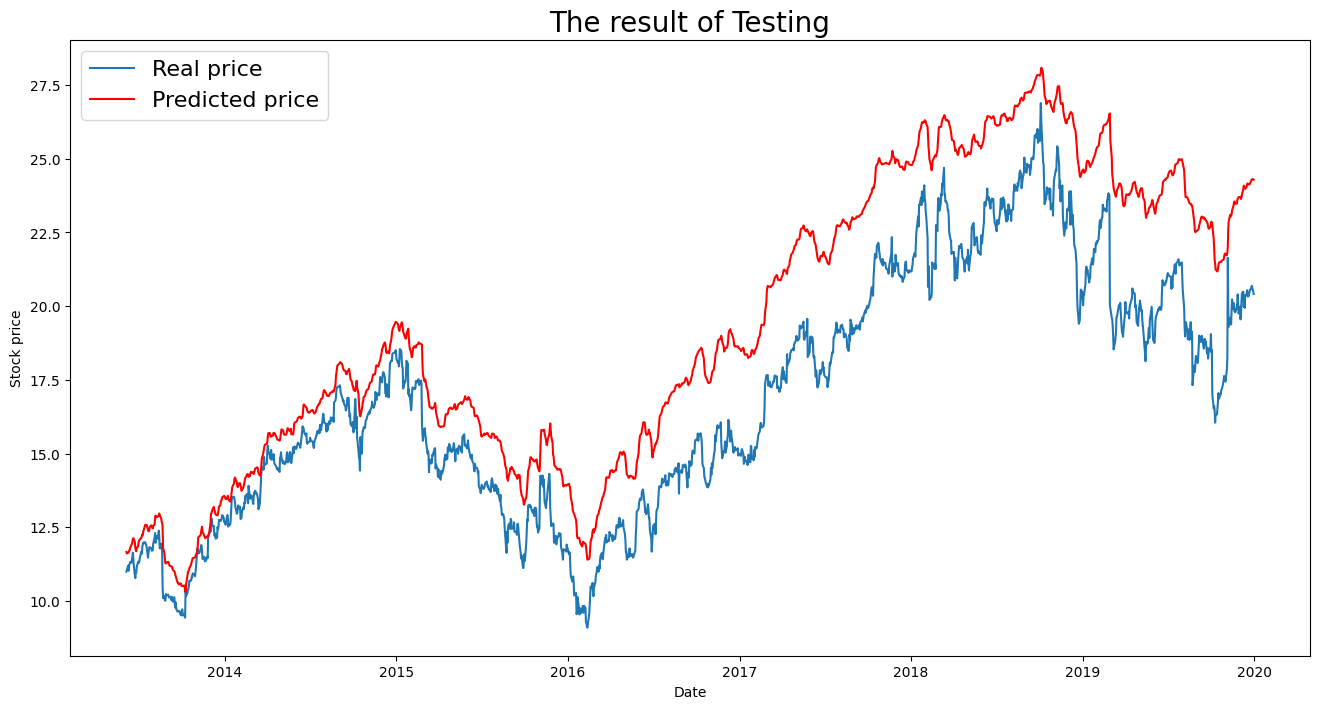

Test RMSE: 2.772806327239406


In [ ]:
test_RMSE = plot_testdataset_result(X_test, y_test)

In [ ]:
def plot_testdataset_with2020_result(X_test, y_test):


    test_yhat = model.predict(X_test, 1, verbose=0)

    y_scaler = load(open('/content/drive/MyDrive/Project/y_scaler.pkl', 'rb'))
    test_predict_index = np.load("/content/drive/MyDrive/Project/index_test.npy", allow_pickle=True)

    rescaled_real_y = y_scaler.inverse_transform(y_test)
    rescaled_predicted_y = y_scaler.inverse_transform(test_yhat)

    predict_result = pd.DataFrame()
    for i in range(rescaled_predicted_y.shape[0]):
        y_predict = pd.DataFrame(rescaled_predicted_y[i], columns=["predicted_price"],
                                 index=test_predict_index[i:i + output_dim])
        predict_result = pd.concat([predict_result, y_predict], axis=1, sort=False)

    real_price = pd.DataFrame()
    for i in range(rescaled_real_y.shape[0]):
        y_train = pd.DataFrame(rescaled_real_y[i], columns=["real_price"],
                               index=test_predict_index[i:i + output_dim])
        real_price = pd.concat([real_price, y_train], axis=1, sort=False)

    predict_result['predicted_mean'] = predict_result.mean(axis=1)
    real_price['real_mean'] = real_price.mean(axis=1)

    # Plot the predicted result
    plt.figure(figsize=(16, 8))
    plt.plot(real_price["real_mean"])
    plt.plot(predict_result["predicted_mean"], color='r')
    plt.xlabel("Date")
    plt.ylabel("Stock price")
    plt.legend(("Real price", "Predicted price"), loc="upper left", fontsize=16)
    plt.title("The result of Testing with 2020", fontsize=20)
    plt.show()

    # Calculate RMSE
    predicted = predict_result["predicted_mean"]
    real = real_price["real_mean"]
    RMSE = np.sqrt(mean_squared_error(predicted, real))
    print('Test RMSE with 2020:', RMSE)

    return RMSE

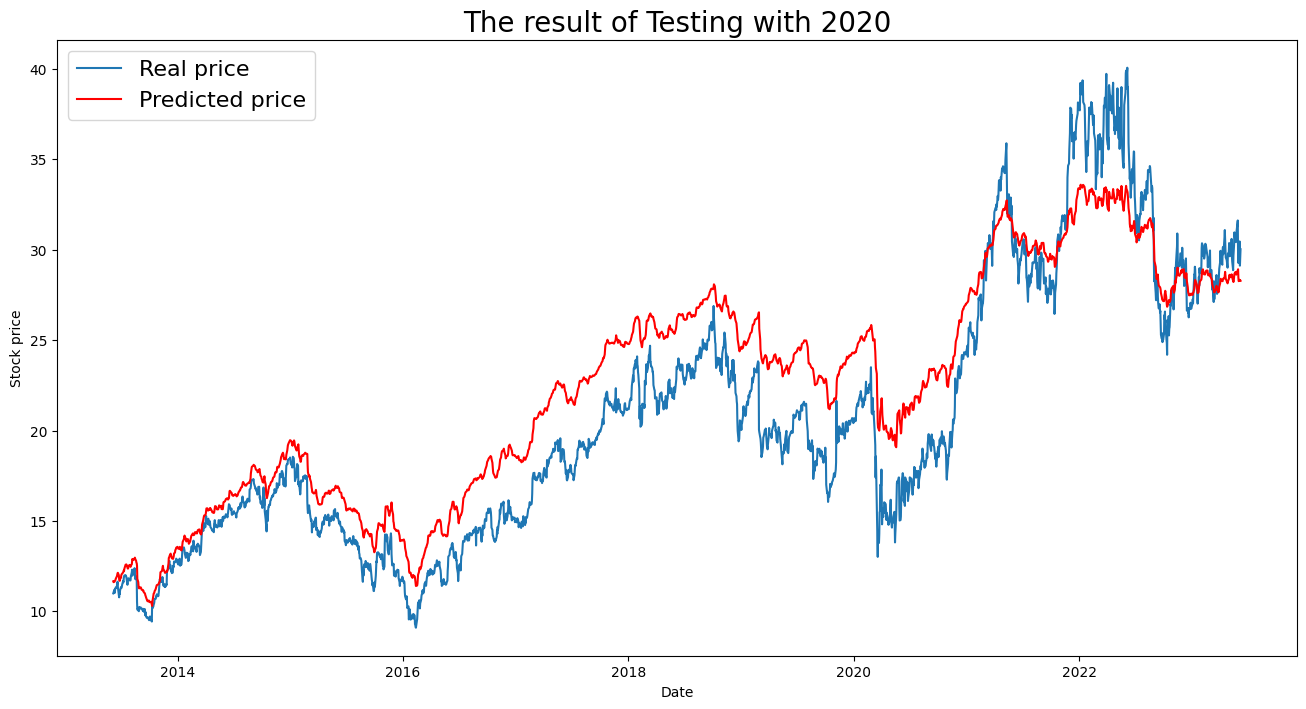

Test RMSE with 2020: 2.8655011135410895


In [ ]:
test_with2020_RMSE = plot_testdataset_with2020_result(X_test, y_test)